In [15]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [16]:
def nice_plot_atoms(ax):
    ax.set(xlim=[-5,5], ylim=[-5,5], xticks=[], yticks=[])

def nice_plot_histogram(ax):
    ax.set(xlim=[-1,7], ylim=[0, 6], xlabel=r'$r$')
    ax.grid(alpha=0.5)

### 8.2 Load the data
Load positions and atomic labels for the 1000 LJG-clusters

In [17]:
data = np.load('clusters_with_atomic_labels.npz')
for key in data:
    print(key, end='')
    if isinstance(data[key],np.ndarray):
        print(f", data['{key}'].shape =",data[key].shape, end='')
    print('')

positions, data['positions'].shape = (1000, 12, 2)
labels, data['labels'].shape = (1000, 12)


Inspect that The first two clusters have these positions and atomic labels

In [18]:
positions = data['positions']
labels = data['labels']
positions[:2], labels[:2]

(array([[[-0.003, -1.024],
         [-0.958, -3.05 ],
         [-0.366,  0.538],
         [-0.902,  2.12 ],
         [-0.15 ,  1.498],
         [ 0.554,  0.835],
         [ 1.27 ,  0.153],
         [ 0.97 , -0.804],
         [ 0.33 , -0.113],
         [ 1.625, -1.508],
         [-1.102,  1.162],
         [-1.269,  0.195]],
 
        [[-1.802, -0.818],
         [-2.143,  1.137],
         [ 1.246,  0.902],
         [-0.158, -1.253],
         [-0.633,  0.391],
         [-0.869, -0.57 ],
         [ 1.695, -0.721],
         [ 0.536,  1.595],
         [ 0.305,  0.641],
         [ 1.   , -0.037],
         [ 0.058, -0.294],
         [ 0.765, -0.974]]]),
 array([[False,  True, False,  True, False, False, False, False, False,
          True, False, False],
        [ True,  True, False, False, False, False, False,  True, False,
         False, False, False]]))

Plot some structures and color the atoms according to their binary label.

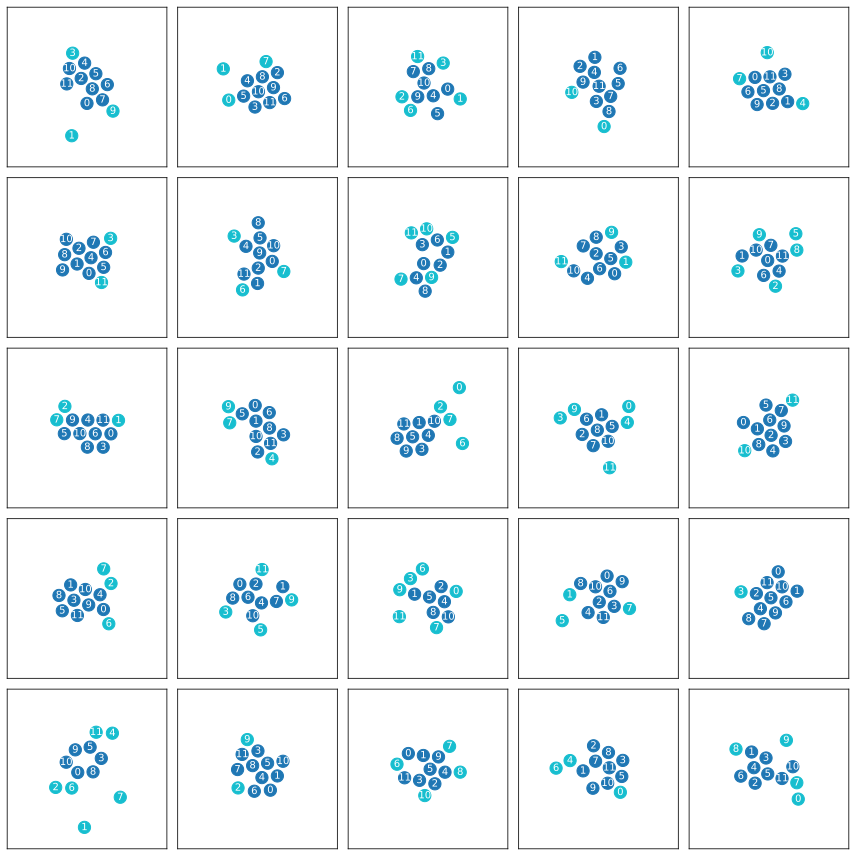

In [19]:
np.random.seed(0)

# Plot the selected clusters
fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):
    # Extract color from the label
    colors = np.where(labels[i], 'C9', 'C0')

    # Plot the cluster
    ax.scatter(*positions[i].T, s=150, c=colors)
    for atom_number, atom_position in enumerate(positions[i]):
        ax.text(*atom_position, str(atom_number), ha='center', va='center', color='white')
    nice_plot_atoms(ax)
plt.tight_layout()

fig.savefig('ex58_fig1.png')

### 8.3
Write a function that, given a distance $r$, will give a feature for the $I$'th atom in a cluster, $\mathcal{C}$

In [20]:
# Distance between atom I and all atoms in cluster C
def r_IJ(C, I):
    return np.linalg.norm(positions[C][I] - positions[C], axis=1)

# Descriptor
def f(C, I, r, r_cut=7, sigma=0.3):
    if r >= r_cut:
        return 0
    else:
        return np.sum(np.exp(-(r_IJ(C, I)-r)**2/(2*sigma**2)) * np.cos(np.pi/2*r/r_cut))

Collect features for 32 evenly spaced $r$s from $0$ to $r_\mathrm {cut}$.

In [21]:
def d_I(C, I, rmin=0, rmax=7, n_steps=32):
    r_arr = np.linspace(rmin, rmax, n_steps)
    return np.array([f(C, I, r) for r in r_arr])

In [22]:
d_I(0,0)

array([1.009e+00, 8.344e-01, 7.329e-01, 1.263e+00, 2.031e+00, 2.421e+00,
       3.035e+00, 4.236e+00, 4.737e+00, 4.091e+00, 3.322e+00, 2.605e+00,
       1.667e+00, 1.004e+00, 8.428e-01, 6.892e-01, 3.598e-01, 1.080e-01,
       1.835e-02, 1.757e-03, 9.472e-05, 2.871e-06, 4.886e-08, 4.656e-10,
       2.476e-12, 7.315e-15, 1.191e-17, 1.056e-20, 4.973e-24, 1.181e-27,
       1.192e-31, 0.000e+00])

Plot the 12 descriptors, one for each atom, in some cluster.

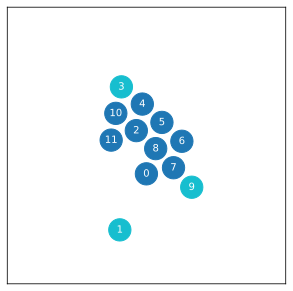

In [23]:
# I'll pick the first cluster
cluster_idx = 0
colors = np.where(labels[cluster_idx], 'C9', 'C0')
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(*positions[cluster_idx].T, s=500, c=colors)
for atom_number, atom_position in enumerate(positions[cluster_idx]):
    ax.text(*atom_position, str(atom_number), ha='center', va='center', color='white')
nice_plot_atoms(ax)

fig.savefig('ex58_fig2.png')

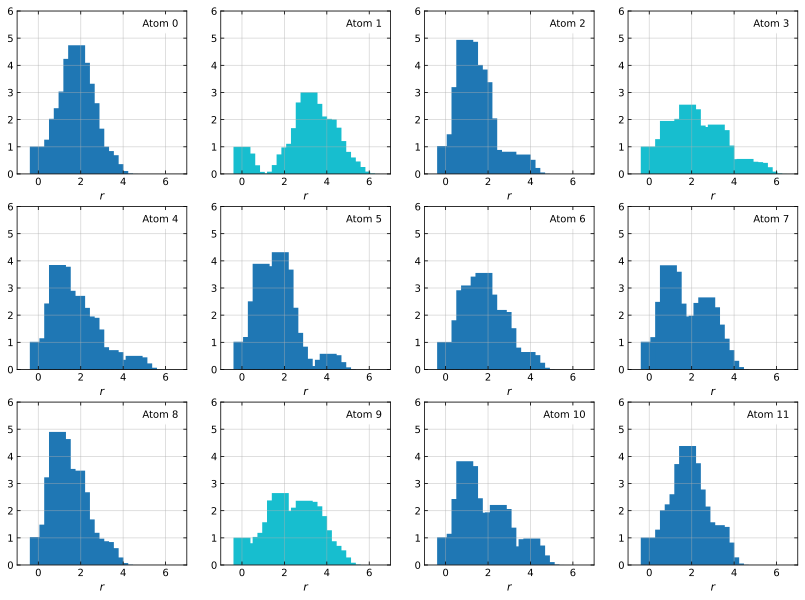

In [24]:
# Plot the descriptors as histograms, one for each atom
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
rmin = 0
rmax = 7
n_steps = 32
for atom_number, ax in enumerate(axes.flatten()):
    r_arr = np.linspace(rmin, rmax, n_steps)
    descriptors = d_I(cluster_idx, atom_number, rmin=rmin, rmax=rmax, n_steps=n_steps)
    ax.bar(r_arr, descriptors, color=colors[atom_number])
    ax.text(0.95, 0.95, f'Atom {atom_number}', ha='right', va='top', backgroundcolor='white', transform=ax.transAxes)
    nice_plot_histogram(ax)

fig.savefig('ex58_fig3.png')

### 8.4 Classifier
Define two classifier networks that are shallow and deep, respectively.

In [25]:
import torch
import torch.nn as nn

# Shallow Classifier
class ShallowClassifier(nn.Module):
    def __init__(self, input_dim=32, output_dim=2):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)  # Single linear layer
    
    def forward(self, x):
        return self.fc(x)  # No activation in the output layer

# Deep Classifier
class DeepClassifier(nn.Module):
    def __init__(self, input_dim=32, hidden_dim=64, output_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First hidden layer
        self.silu1 = nn.SiLU()  # SiLU activation
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.silu2 = nn.SiLU()  # SiLU activation
        self.fc3 = nn.Linear(hidden_dim, output_dim)  # Output layer
    
    def forward(self, x):
        x = self.silu1(self.fc1(x))  # Hidden layer 1 with activation
        x = self.silu2(self.fc2(x))  # Hidden layer 2 with activation
        return self.fc3(x)  # Output logits

from torch.utils.data import Dataset, DataLoader
class AtomicDataset(Dataset):
    def __init__(self, descriptors, labels):
        self.descriptors = descriptors
        self.labels = labels

    def __len__(self):
        return len(self.descriptors)

    def __getitem__(self, idx):
        return self.descriptors[idx], self.labels[idx]

class EarlyStopping:
    def __init__(self, patience=5):
        # patience (int): How many epochs to wait after last time validation loss improved.
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def split_data(data_tensor, labels_tensor, val_size=0.1, test_size=0.1, custom_dataset=None, batch_size=32, verbose=True):
    """
    Splits data into training, validation, and test sets and optionally returns PyTorch Datasets and DataLoaders.
    
    Args:
        data_tensor (torch.Tensor): Tensor containing data points.
        labels_tensor (torch.Tensor): Tensor containing labels.
        val_size (float): Fraction of data to be used for validation.
        test_size (float): Fraction of data to be used for testing.
        custom_dataset (Dataset, optional): PyTorch Dataset class for wrapping data and labels.
        batch_size (int): Batch size for DataLoaders.
        verbose (bool): Whether to print dataset sizes.
    
    Returns:
        If `custom_dataset` is None:
            Tensors for train_data, train_labels, val_data, val_labels, test_data, test_labels.
        If `custom_dataset` is provided:
            Tuple of Datasets and DataLoaders for train, validation, and test sets.
    """
    # Validate splits
    if val_size + test_size >= 1:
        raise ValueError("val_size + test_size must be less than 1.")

    # Compute split sizes
    train_size = 1 - val_size - test_size
    n_tot = len(data_tensor)
    n_train = int(train_size * n_tot)
    n_val = int(val_size * n_tot)
    n_test = n_tot - n_train - n_val

    # Shuffle indices
    indices = torch.randperm(n_tot)

    # Split indices
    train_indices = indices[:n_train]
    val_indices = indices[n_train:n_train + n_val]
    test_indices = indices[n_train + n_val:]

    # Split data and labels
    train_data, val_data, test_data = (
        data_tensor[train_indices],
        data_tensor[val_indices],
        data_tensor[test_indices]
    )
    train_labels, val_labels, test_labels = (
        labels_tensor[train_indices],
        labels_tensor[val_indices],
        labels_tensor[test_indices]
    )

    if verbose:
        print(f'Training data: {len(train_data)} samples')
        print(f'Validation data: {len(val_data)} samples')
        print(f'Test data: {len(test_data)} samples')

    # Return raw splits if no custom_dataset is provided
    if not custom_dataset:
        return train_data, train_labels, val_data, val_labels, test_data, test_labels

    # Wrap data in PyTorch Datasets and create DataLoaders
    train_dataset = custom_dataset(train_data, train_labels)
    val_dataset = custom_dataset(val_data, val_labels)
    test_dataset = custom_dataset(test_data, test_labels)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataset, train_dataloader, val_dataset, val_dataloader, test_dataset, test_dataloader

In [26]:
# Compute descriptors for all atoms
all_descriptors = []
all_labels = []

for C in range(positions.shape[0]):  # Iterate over clusters
    for I in range(positions.shape[1]):  # Iterate over atoms in a cluster
        descriptor = d_I(C, I)  # Compute descriptor for atom I in cluster C
        all_descriptors.append(descriptor)
        all_labels.append(labels[C][I])  # Add the binary label for atom I

# Convert descriptors and labels to tensors
descriptors_tensor = torch.tensor(all_descriptors, dtype=torch.float32)
labels_tensor = torch.tensor(all_labels, dtype=torch.long)

# Split data into training, validation, and test sets
train_dataset, train_dataloader, val_dataset, val_dataloader, test_dataset, test_dataloader = split_data(
    descriptors_tensor, labels_tensor, val_size=0.1, test_size=0.1, custom_dataset=AtomicDataset, batch_size=32
)

Training data: 9600 samples
Validation data: 1200 samples
Test data: 1200 samples


C:\Users\Jakob\AppData\Local\Temp\ipykernel_22712\3369714642.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  labels_tensor = torch.tensor(all_labels, dtype=torch.long)


In [27]:
def train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs, early_stopping=None):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(n_epochs), desc=f"Training {model.__class__.__name__}"):
        model.train()  # Set the model to training mode
        total_train_loss = 0

        # Training loop
        for batch_descriptors, batch_labels in train_dataloader:
            optimizer.zero_grad()  # Reset gradients

            # Forward pass
            outputs = model(batch_descriptors)
            
            # Compute loss
            loss = loss_fn(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Compute average training loss
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():  # No gradient computation
            for batch_descriptors, batch_labels in val_dataloader:
                outputs = model(batch_descriptors)
                loss = loss_fn(outputs, batch_labels)
                total_val_loss += loss.item()

        # Compute average validation loss
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        # Early stopping
        if early_stopping is not None:
            early_stopping(avg_val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

    return train_losses, val_losses, model

Training ShallowClassifier:  94%|█████████▍| 94/100 [00:19<00:01,  4.94it/s]

Early stopping triggered at epoch 95


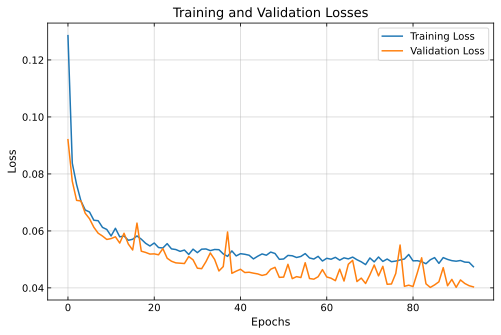

In [28]:
# Initialize model, loss function, and optimizer
model = ShallowClassifier()  # Or DeepClassifier()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Create an EarlyStopping instance
early_stopping = EarlyStopping(patience=10)

# Train the model
train_losses, val_losses, trained_model = train_model(
    model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=100, early_stopping=early_stopping
)

# Plot the losses
fig, ax = plt.subplots(figsize=(8, 5))  # Create a single subplot
ax.plot(train_losses, label="Training Loss")
ax.plot(val_losses, label="Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Losses")
ax.legend()
ax.grid(alpha=0.5)

fig.savefig('ex58_fig4.png')

In [29]:
def get_predicted_labels(model, positions, d_I):
    model.eval()  # Set the model to evaluation mode
    predicted_labels = []

    with torch.no_grad():  # Disable gradient computation
        for C in range(len(positions)):  # Iterate over clusters
            cluster_predictions = []
            for I in range(len(positions[C])):  # Iterate over atoms in the cluster
                descriptor = torch.tensor(d_I(C, I), dtype=torch.float32).unsqueeze(0)  # Descriptor as input
                output = model(descriptor)  # Get model output
                predicted_label = torch.argmax(output, dim=1).item()  # Predicted class
                cluster_predictions.append(bool(predicted_label))
            predicted_labels.append(cluster_predictions)

    # Convert to numpy array
    return np.array(predicted_labels, dtype=bool)

In [30]:
predicted_labels = get_predicted_labels(trained_model, positions, d_I)

# Verify shape
print(predicted_labels.shape)  # Output: (1000, 12)

# Inspect some predictions
print(predicted_labels[:2])  # First two clusters' predicted labels

(1000, 12)
[[False  True False  True False False False False False  True False False]
 [ True  True False False False False False  True False False False False]]


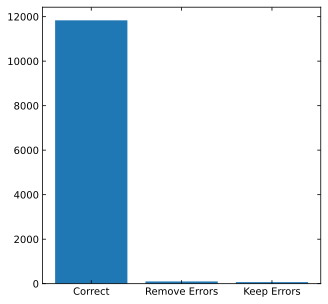

In [31]:
N_total = labels.size
N_correct = np.sum(predicted_labels == labels)
N_remove_errors = np.sum(np.logical_and(predicted_labels, ~labels))
N_keep_errors = np.sum(np.logical_and(~predicted_labels, labels))

# Plot as histogram
fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(["Correct", "Remove Errors", "Keep Errors"], [N_correct, N_remove_errors, N_keep_errors])

fig.savefig('ex58_fig5.png')

Let's finish the exercise properly! :D

Training DeepClassifier: 100%|██████████| 1000/1000 [00:22<00:00, 44.20it/s]


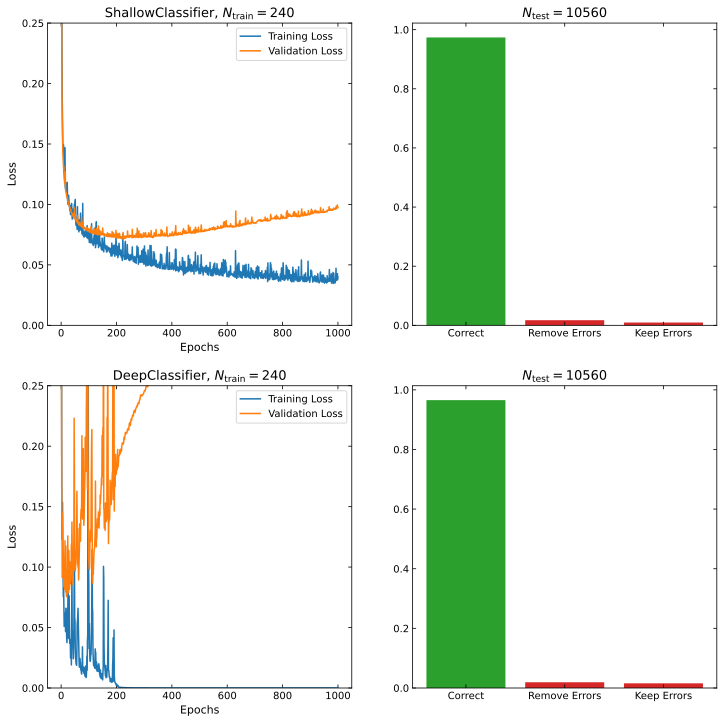

In [32]:
# No early stopping, 
models = [ShallowClassifier(), DeepClassifier()]
n_epochs = 1000

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for model, row in zip(models, axes):
    # Split data into training, validation, and test sets
    train_dataset, train_dataloader, val_dataset, val_dataloader, test_dataset, test_dataloader = split_data(
        descriptors_tensor, labels_tensor, val_size=0.1, test_size=0.88, custom_dataset=AtomicDataset, batch_size=32, verbose=False
    )

    # Initialize model, loss function, and optimizer, and train the model
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    train_losses, val_losses, trained_model = train_model(
        model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=n_epochs
    )

    # Plot the losses as a function of epochs
    row[0].plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
    row[0].plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    row[0].set(xlabel="Epochs", ylabel="Loss", title=fr'{model.__class__.__name__}, $N_\mathrm{{train}} = {len(train_dataset)}$', ylim=[0, 0.25])
    row[0].legend()

    # Plot the predicted labels in a histogram
    predicted_labels = get_predicted_labels(trained_model, positions, d_I)
    N_total = labels.size
    N_correct = np.sum(predicted_labels == labels)
    N_remove_errors = np.sum(np.logical_and(predicted_labels, ~labels))
    N_keep_errors = np.sum(np.logical_and(~predicted_labels, labels))

    categories = ["Correct", "Remove Errors", "Keep Errors"]
    counts = [N_correct, N_remove_errors, N_keep_errors]
    fractions = [count / N_total for count in counts]

    row[1].bar(categories, fractions, color=['C2', 'C3', 'C3'])
    row[1].set(title=fr'$N_\mathrm{{test}} = {len(test_dataset)}$')

fig.savefig('ex58_fig6.png')

Training ShallowClassifier:  43%|████▎     | 434/1000 [00:06<00:08, 64.79it/s]


Early stopping triggered at epoch 435


Training DeepClassifier:  15%|█▌        | 154/1000 [00:03<00:18, 45.81it/s]


Early stopping triggered at epoch 155


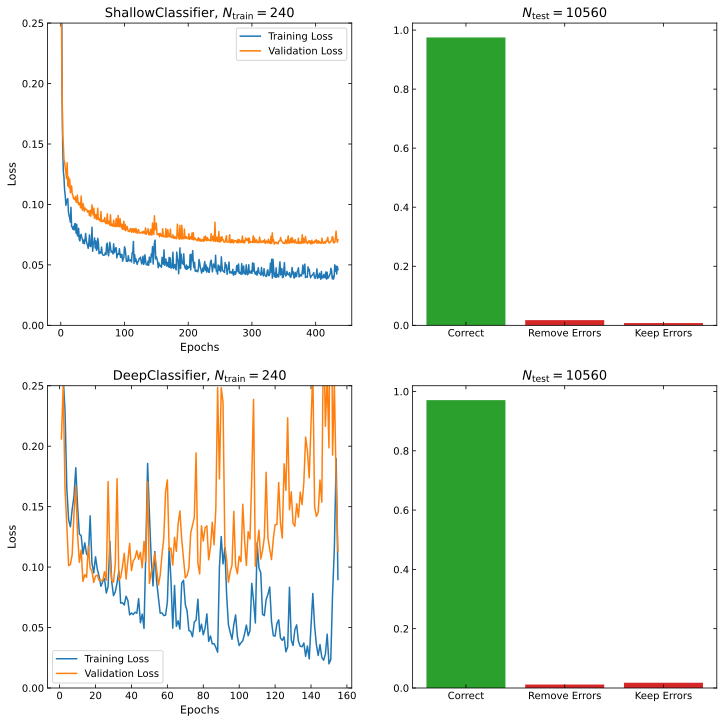

In [33]:
# With early stopping, 
models = [ShallowClassifier(), DeepClassifier()]
n_epochs = 1000
patience = 100

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for model, row in zip(models, axes):
    # Split data into training, validation, and test sets
    train_dataset, train_dataloader, val_dataset, val_dataloader, test_dataset, test_dataloader = split_data(
        descriptors_tensor, labels_tensor, val_size=0.1, test_size=0.88, custom_dataset=AtomicDataset, batch_size=32, verbose=False
    )

    # Initialize model, loss function, optimizer, and early stoppiong, and train the model
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    early_stopping = EarlyStopping(patience=patience)
    train_losses, val_losses, trained_model = train_model(
        model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=n_epochs, early_stopping=early_stopping
    )

    # Plot the losses as a function of epochs
    row[0].plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
    row[0].plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    row[0].set(xlabel="Epochs", ylabel="Loss", title=fr'{model.__class__.__name__}, $N_\mathrm{{train}} = {len(train_dataset)}$', ylim=[0, 0.25])
    row[0].legend()

    # Plot the predicted labels in a histogram
    predicted_labels = get_predicted_labels(trained_model, positions, d_I)
    N_total = labels.size
    N_correct = np.sum(predicted_labels == labels)
    N_remove_errors = np.sum(np.logical_and(predicted_labels, ~labels))
    N_keep_errors = np.sum(np.logical_and(~predicted_labels, labels))

    categories = ["Correct", "Remove Errors", "Keep Errors"]
    counts = [N_correct, N_remove_errors, N_keep_errors]
    fractions = [count / N_total for count in counts]

    row[1].bar(categories, fractions, color=['C2', 'C3', 'C3'])
    row[1].set(title=fr'$N_\mathrm{{test}} = {len(test_dataset)}$')

fig.savefig('ex58_fig7.png')

Training DeepClassifier:  20%|██        | 200/1000 [00:55<03:42,  3.60it/s]

Early stopping triggered at epoch 201


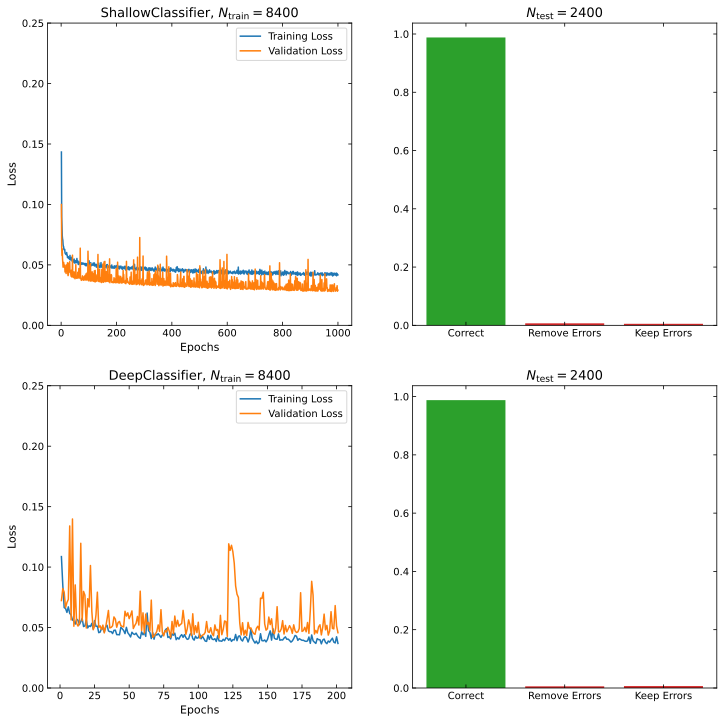

In [34]:
# With more training data
models = [ShallowClassifier(), DeepClassifier()]
n_epochs = 1000
patience = 100

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for model, row in zip(models, axes):
    # Split data into training, validation, and test sets
    train_dataset, train_dataloader, val_dataset, val_dataloader, test_dataset, test_dataloader = split_data(
        descriptors_tensor, labels_tensor, val_size=0.1, test_size=0.2, custom_dataset=AtomicDataset, batch_size=32, verbose=False
    )

    # Initialize model, loss function, optimizer, and early stoppiong, and train the model
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    early_stopping = EarlyStopping(patience=patience)
    train_losses, val_losses, trained_model = train_model(
        model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=n_epochs, early_stopping=early_stopping
    )

    # Plot the losses as a function of epochs
    row[0].plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
    row[0].plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    row[0].set(xlabel="Epochs", ylabel="Loss", title=fr'{model.__class__.__name__}, $N_\mathrm{{train}} = {len(train_dataset)}$', ylim=[0, 0.25])
    row[0].legend()

    # Plot the predicted labels in a histogram
    predicted_labels = get_predicted_labels(trained_model, positions, d_I)
    N_total = labels.size
    N_correct = np.sum(predicted_labels == labels)
    N_remove_errors = np.sum(np.logical_and(predicted_labels, ~labels))
    N_keep_errors = np.sum(np.logical_and(~predicted_labels, labels))

    categories = ["Correct", "Remove Errors", "Keep Errors"]
    counts = [N_correct, N_remove_errors, N_keep_errors]
    fractions = [count / N_total for count in counts]

    row[1].bar(categories, fractions, color=['C2', 'C3', 'C3'])
    row[1].set(title=fr'$N_\mathrm{{test}} = {len(test_dataset)}$')

fig.savefig('ex58_fig8.png')

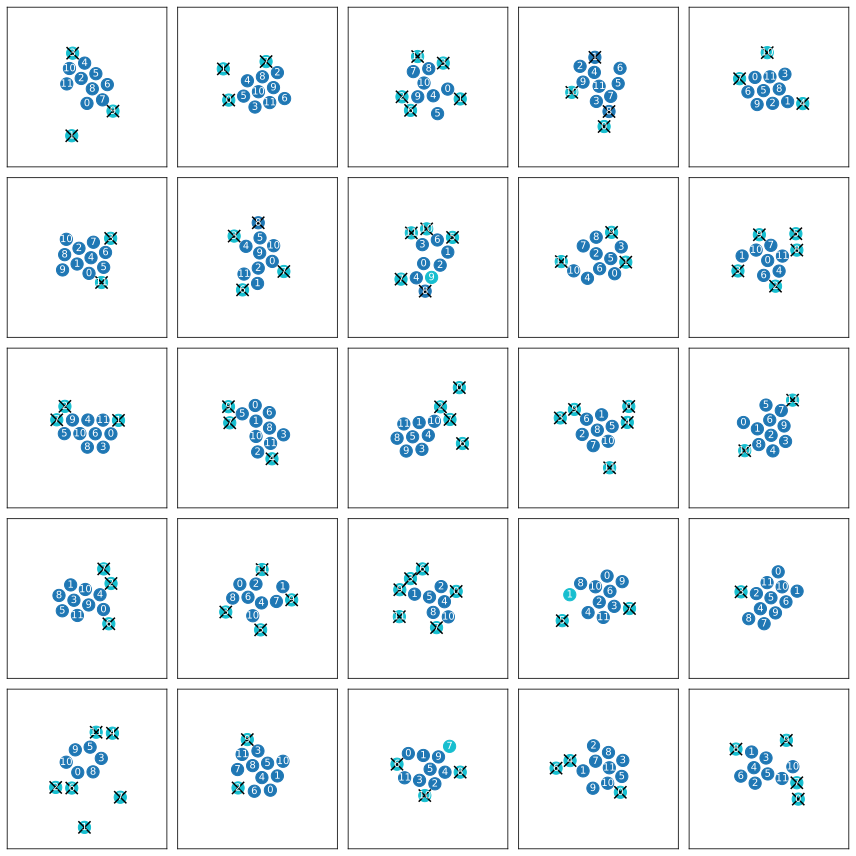

In [35]:
np.random.seed(0)

# Plot the selected clusters
fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):
    # Extract color from the label
    colors = np.where(labels[i], 'C9', 'C0')

    # Plot the cluster
    ax.scatter(*positions[i].T, s=150, c=colors)
    for atom_number, atom_position in enumerate(positions[i]):
        ax.text(*atom_position, str(atom_number), ha='center', va='center', color='white')
    nice_plot_atoms(ax)

    # Plot the predicted labels
    markers = np.where(predicted_labels[i], 'x', 'none')
    for j, pos in enumerate(positions[i]):
        ax.scatter(*pos, s=150, marker=markers[j], c='k', zorder=2)
plt.tight_layout()

fig.savefig('ex58_fig9.png')